In [1]:
!pip install spatialde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for NaiveDE: filename=NaiveDE-1.2.0-py3-none-any.whl size=5712 sha256=22681eb3f703f8bfdc3ae08d8f268a937903ca655df659a775cbfab7d633d582
  Stored in directory: /root/.cache/pip/wheels/01/34/53/eff6dafc79c8f34e98fce9705fbcbc458461172e53adb65d16
Successfully built NaiveDE


In [ ]:
#This isn't needed as it does not always work rather download the data described in the next cell 
!git clone https://github.com/Teichlab/SpatialDE.git

In [ ]:
#To download data go to figure share https://figshare.com/articles/software/SpatialDE/17065217 if cloning git repo and using git lfs fails

In [2]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

import NaiveDE
import SpatialDE


Populating the interactive namespace from numpy and matplotlib


###Mount google drive 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Saving Rep11_MOB_0.csv to Rep11_MOB_0.csv


###Load data from google drive



###Analysis of MERFISH data Moffitt, J.R. et al. Proc. Natl. Acad. Sci. USA (140 probes in human osteosarcoma cell line)
####Data can be downloaded from the figshare link above

In [3]:
counts = pd.read_csv('/content/drive/MyDrive/SpatialDEData/Analysis/MERFISH/data/rep6/middle_exp_mat.csv', index_col=0)
counts = counts.T[counts.sum(0) >= 3].T  # Filter practically unobserved genes

print(counts.shape)
counts.iloc[:5, :5]


(1056, 140)


,AFAP1,AFF4,AGAP1,AGO3,AGPS
cellID,,,,,
16345,5.0,11.0,10.0,1.0,5.0
16347,2.0,1.0,5.0,3.0,2.0
16348,6.0,12.0,20.0,4.0,8.0
16349,6.0,11.0,11.0,9.0,9.0
16351,5.0,12.0,16.0,7.0,10.0


####Load sample information and align count matrix with metadata


In [4]:
sample_info = pd.read_csv('/content/drive/MyDrive/SpatialDEData/Analysis/MERFISH/data/rep6/middle_sample_info.csv', index_col=0)
counts = counts.loc[sample_info.index]
    
X = sample_info[['abs_X', 'abs_Y']]




#sample_info = pd.read_csv('/content/drive/MyDrive/SpatialDEData/Analysis/MouseOB/MOB_sample_info.csv', index_col=0)
#counts = counts.loc[sample_info.index]  # Align count matrix with metadata table

sample_info.head(5)


,abs_X,abs_Y,nucleusArea,cytoplasmArea,total_count
cellID,,,,,
16345,-438.999143,-312.475845,193.036072,1040.400991,828.0
16347,-437.428582,-334.316858,214.738917,472.263443,557.0
16348,-432.656618,-438.886660,276.365457,1083.329695,961.0
16349,-429.781788,-411.289794,292.249077,1597.377076,1745.0
16351,-412.916125,-358.068636,179.632777,887.384010,1151.0


####Plot x and y coordinates of the spatial samples

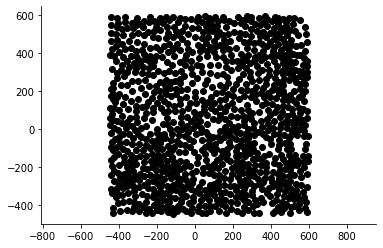

In [5]:
figsize(6, 4)
plt.scatter(sample_info['abs_X'], sample_info['abs_Y'], c='k');
plt.axis('equal');


##### "Our method assumes normally distributed noise, but the data we are using is from expression counts, and empirically seems to follow a negative binomial distribution. We use technique by Anscombe to approximately transform the data to normal distributed noise."

"Secondly, library size or sequencing depth of the spatial samples will bias the expression of every gene. We use linear regression to account for this effect before performing the spatial test."



In [6]:
norm_expr = NaiveDE.stabilize(counts.T).T
resid_expr = NaiveDE.regress_out(sample_info, norm_expr.T, 'np.log(total_count)').T

# Add total_count as pseudogene for reference
resid_expr['log_total_count'] = np.log(sample_info['total_count'])

resid_expr.head()


,AFAP1,AFF4,AGAP1,AGO3,AGPS,AHDC1,AKAP11,ALPK2,AMOTL1,ANKH,...,USP8,USP9X,VPS13D,XDH,XKR5,YIPF4,ZBTB43,ZCCHC6,ZNF592,log_total_count
cellID,,,,,,,,,,,,,,,,,,,,,
16345,-4.813842,-3.188008,-3.295723,-4.979079,-4.386973,-4.217989,-4.550988,-3.851629,-4.496431,-4.706234,...,-3.461996,-4.570440,-4.146216,-3.051070,-4.715197,-4.041038,-3.420221,-4.964112,-5.160414,6.719013
16347,-5.106487,-4.619450,-3.560939,-3.964551,-4.704805,-3.862786,-4.689495,-3.509033,-4.503137,-5.049473,...,-4.373514,-4.439820,-4.025982,-3.543440,-5.032331,-3.364482,-4.997824,-4.605185,-4.372846,6.322565
16348,-4.807822,-3.234243,-2.778112,-4.207361,-4.122122,-5.429884,-4.000813,-4.313334,-4.445551,-3.748182,...,-4.417784,-4.647323,-4.274092,-3.749924,-4.630711,-3.068239,-4.092458,-4.596254,-4.137827,6.867974
16349,-5.395198,-3.818007,-3.841525,-4.026636,-4.566920,-4.284435,-4.145430,-3.556760,-5.135194,-4.230258,...,-4.616071,-4.750019,-3.917865,-3.001370,-4.083341,-2.984517,-3.884148,-3.810366,-4.886620,7.464510
16351,-5.138158,-3.386704,-3.141760,-3.895067,-4.088872,-4.111033,-4.520603,-4.003824,-4.135164,-4.294359,...,-4.958653,-4.630152,-3.846620,-3.891029,-5.693100,-3.879179,-3.836398,-3.604869,-5.261995,7.048386


####This is the key step to get the results. Here I am running for all 140 genes sampled but you can decide how many you want to look at. (Takes about 12 seconds for 1056 spots x 140 genes count matrix)

In [7]:
sample_resid_expr = resid_expr.sample(n=140, axis=1, random_state=1)

X = sample_info[['abs_X', 'abs_Y']]
results = SpatialDE.run(X, sample_resid_expr)


/usr/local/lib/python3.8/dist-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/usr/local/lib/python3.8/dist-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

In [8]:
# Assign pi_0 = 1 in multiple testing correction
results['qval'] = SpatialDE.util.qvalue(results['pval'], pi0=1.0)


####Visualize results

In [9]:
results.head().T


,0,1,2,3,4
FSV,0.216186,0.333515,0.310268,0.311262,0.161714
M,4,4,4,4,4
g,NKTR,SULT1C2,CDYL2,DSEL,DOPEY1
l,14.490174,14.490174,14.490174,14.490174,14.490174
max_delta,3.623817,1.997364,2.2219,2.211611,5.181158
max_ll,-423.198369,-639.599553,-528.863103,-667.427585,-672.861371
max_mu_hat,-3.136666,-4.399941,-4.636538,-4.640976,-4.264494
max_s2_t_hat,1.942896,5.58924,5.811592,5.853814,2.748364
model,SE,SE,SE,SE,SE
n,1056,1056,1056,1056,1056


####Extract genes (g), A parameter indicating the distance scale a gene changes expression over (l), qvalues (qval)

In [10]:
results.sort_values('qval').head(10)[['g', 'l', 'qval']]

,g,l,qval
42,THBS1,54.555049,0.000000e+00
43,SPTBN1,54.555049,0.000000e+00
41,FASN,54.555049,0.000000e+00
36,PRKDC,54.555049,3.885781e-14
52,BSN,105.856034,1.865175e-13
46,COL5A1,54.555049,2.460994e-13
45,ANKRD52,54.555049,2.575717e-13
34,CENPF,28.116048,3.283485e-13
51,MALAT1,54.555049,9.153172e-13
47,log_total_count,54.555049,4.263478e-12


####Visualize the spatially differentially expressed genes

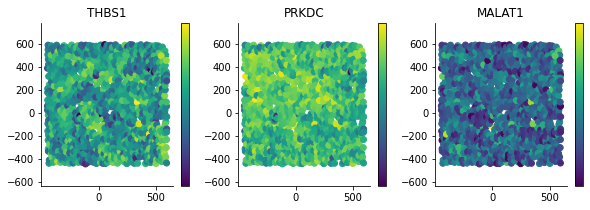

In [11]:
figsize(10, 3)
for i, g in enumerate(['THBS1', 'PRKDC', 'MALAT1']):
    plt.subplot(1, 3, i + 1)
    plt.scatter(sample_info['abs_X'], sample_info['abs_Y'], c=norm_expr[g]);
    plt.title(g)
    plt.axis('equal')


    plt.colorbar(ticks=[]);


####Genes that are not spatially differentially expressed

In [12]:
results.sort_values('qval').tail(10)[['g', 'l', 'qval']]


,g,l,qval
98,FZD5,205.398037,0.413059
20,DIEXF,14.490174,0.466154
126,UBR2,205.398037,0.478987
9,FAF2,14.490174,0.536441
92,YIPF4,205.398037,0.539120
14,SKP1,14.490174,0.563288
85,STARD9,205.398037,0.563288
118,SMIM5,205.398037,0.610077
107,TSTD2,205.398037,0.805918
38,CRTAP,54.555049,0.987713


####Visualize genes that are not spatially differentially expressed

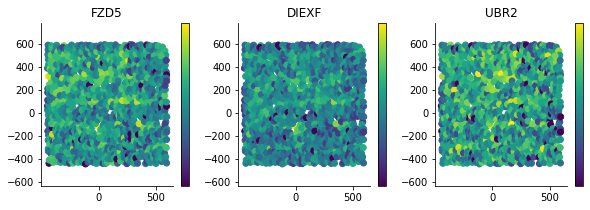

In [13]:
figsize(10, 3)
for i, g in enumerate(['FZD5', 'DIEXF', 'UBR2']):
    plt.subplot(1, 3, i + 1)
    plt.scatter(sample_info['abs_X'], sample_info['abs_Y'], c=norm_expr[g]);
    plt.title(g)
    plt.axis('equal')


    plt.colorbar(ticks=[]);


####In regular differential expression analysis, we usually investigate the relation between significance and effect size by so called volcano plots. We don't have the concept of fold change in our case, but we can investigate the fraction of variance explained by spatial variation.

##### This is a great way to visualize how much spatial variance can be explained by genes

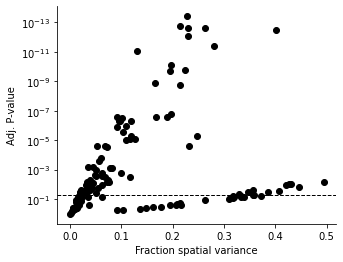

In [14]:
figsize(5, 4)
plt.yscale('log')

plt.scatter(results['FSV'], results['qval'], c='black')

plt.axhline(0.05, c='black', lw=1, ls='--');

plt.gca().invert_yaxis();
plt.xlabel('Fraction spatial variance')
plt.ylabel('Adj. P-value');


#The above code is to identify differentially expressed genes. The below code helps identify differentially expressed genes + using model_search helps classify genes into interpretable fitting classes (periodic, linear etc). 

In [19]:
results = SpatialDE.run(X, sample_resid_expr)
de_results = results[(results.qval < 0.05)].copy()
ms_results = SpatialDE.model_search(X, resid_expr, de_results)


/usr/local/lib/python3.8/dist-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/usr/local/lib/python3.8/dist-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/SpatialDE/base.py:56: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/SpatialDE/base.py:476: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  ms_results = ms_results.drop(transfer_columns, 1) \


In [20]:
ms_results.head().T

,0,1,2,3,4
BIC,870.546617,1085.200739,1358.102824,1368.593958,1016.801001
FSV,0.0,0.0,0.006528,0.0,0.0
LLR,NaN,NaN,NaN,NaN,NaN
M,3,3,3,3,3
g,NKTR,CDYL2,DSEL,DOPEY1,PROSER1
l,NaN,NaN,NaN,NaN,NaN
max_delta,485165195.40979,485165195.40979,45.337401,485165195.40979,485165195.40979
max_ll,-424.829943,-532.157004,-668.608047,-673.853614,-497.957135
max_mu_hat,-3.136251,-4.635683,-4.650208,-4.264622,-4.263063
max_s2_t_hat,0.0,0.0,0.443355,0.0,0.0


In [22]:
results['pval'] = results['pval'].clip(lower=results.query('pval > 0')['pval'].min() / 2, upper=None)
results['qval'] = results['qval'].clip(lower=results.query('pval > 0')['pval'].min() / 2, upper=None)
ms_results['pval'] = ms_results['pval'].clip(lower=ms_results.query('pval > 0')['pval'].min() / 2, upper=None)
ms_results['qval'] = ms_results['qval'].clip(lower=ms_results.query('qval > 0')['qval'].min() / 2, upper=None)


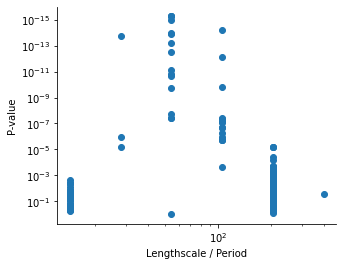

In [23]:
plt.loglog()
plt.scatter(results.l, results.pval);
plt.gca().invert_yaxis();
plt.xlabel('Lengthscale / Period')
plt.ylabel('P-value');


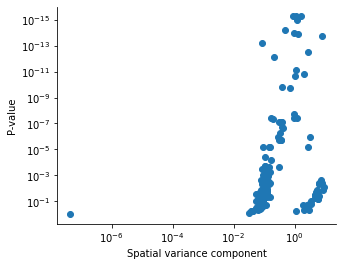

In [24]:
plt.loglog()
plt.scatter(results.max_s2_t_hat, results.pval);
plt.gca().invert_yaxis();
plt.xlabel('Spatial variance component')
plt.ylabel('P-value');


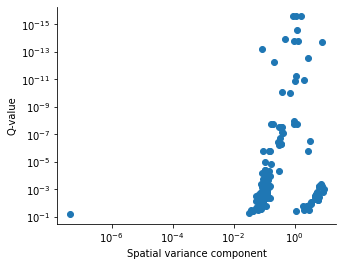

In [25]:
plt.loglog()
plt.scatter(results.max_s2_t_hat, results.qval);
plt.gca().invert_yaxis();
plt.xlabel('Spatial variance component')
plt.ylabel('Q-value');


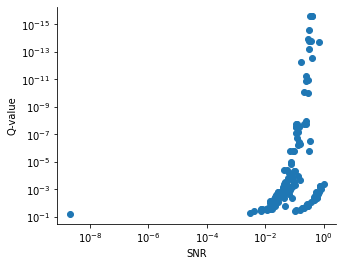

In [26]:
plt.loglog()
plt.scatter(1./results.max_delta, results.qval);
plt.gca().invert_yaxis();
plt.xlabel('SNR')
plt.ylabel('Q-value');


In [27]:
results.query('qval < 0.05').shape


(138, 18)

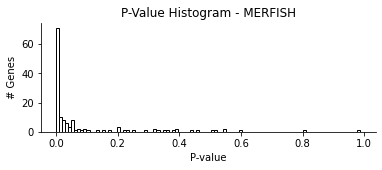

In [28]:
figsize(6, 2)
plt.hist(results.query('pval < 1.')['pval'], bins=100, color='w', ec='k');
plt.title('P-Value Histogram - MERFISH')
plt.ylabel('# Genes')
plt.xlabel('P-value');
# plt.ylim(ymax=400)


In [29]:
ms_results.model.value_counts()


SE        69
linear    37
PER       32
Name: model, dtype: int64

In [30]:
N = 5
top_per_ls = ms_results.query('qval < 0.05') \
                  .sort_values('qval', ascending=True) \
                  .groupby(['model', 'l']) \
                  .head(N) \
                  .sort_values(['l', 'qval'], ascending=[True, True])
                
top_per_ls


,BIC,FSV,LLR,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,...,n,s2_FSV,s2_logdelta,time,PER_prob,SE_prob,linear_prob,pval,qval,max_ll_null
76,734.408916,0.493937,9.172251,4,HERC2,14.490174,1.024034,-353.279971,-4.355470,7.576619,...,1056,0.002803,0.052512,0.009265,2.861740e-04,9.997024e-01,1.139789e-05,2.457122e-03,4.136569e-04,-362.452222
77,1464.841428,0.446784,7.108275,4,AFAP1,14.490174,1.237594,-718.496227,-4.914279,8.920527,...,1056,0.003070,0.058547,0.003430,8.060854e-02,8.811224e-01,3.826910e-02,7.672891e-03,1.010921e-03,-725.604502
79,1350.547520,0.406597,5.991232,4,POLQ,14.490174,1.458701,-661.349273,-4.920365,8.256945,...,1056,0.003642,0.072143,0.004028,3.244041e-03,9.902144e-01,6.541554e-03,1.437715e-02,1.697421e-03,-667.340505
75,1360.301630,0.345980,5.572456,4,PAPPA,14.490174,1.889391,-666.226328,-4.079214,4.971344,...,1056,0.002484,0.054523,0.009586,1.852006e-02,9.667229e-01,1.475700e-02,1.824515e-02,2.058051e-03,-671.798784
78,1385.104416,0.386644,5.418595,4,ANKH,14.490174,1.585562,-678.627721,-4.180206,5.737177,...,1056,0.003411,0.069451,0.004006,3.568854e-04,9.793075e-01,2.033560e-02,1.992339e-02,2.207904e-03,-684.046316
81,2454.467251,0.401525,58.663360,4,CENPF,28.116048,1.485120,-1213.309139,-6.898914,8.059880,...,1056,0.000053,0.001052,0.004548,1.392997e-41,1.000000e+00,3.963544e-39,1.876277e-14,2.132133e-14,-1271.972498
82,1194.271943,0.246855,23.890163,4,PRKCA,28.116048,3.039939,-583.211485,-4.837368,3.081164,...,1056,0.000070,0.002110,0.006197,1.332596e-11,1.000000e+00,1.875587e-18,1.019916e-06,3.311415e-07,-607.101648
80,904.730806,0.231011,20.307930,4,CBX5,28.116048,3.316767,-438.440916,-4.578621,2.655469,...,1056,0.000094,0.003079,0.007271,1.147114e-16,1.000000e+00,2.424521e-15,6.592677e-06,1.712384e-06,-458.748846
89,732.310281,0.281596,72.673145,4,SPTBN1,54.555049,2.513125,-352.230653,-4.411110,1.099691,...,1056,0.000053,0.001391,0.005193,1.442594e-39,1.000000e+00,1.346459e-55,5.551115e-16,1.261617e-15,-424.903798
88,2264.530016,0.282766,76.475628,4,THBS1,54.555049,2.498648,-1118.340521,-5.164218,1.617516,...,1056,0.000050,0.001306,0.005316,6.995655e-42,1.000000e+00,1.354063e-54,5.551115e-16,1.261617e-15,-1194.816149


In [31]:
top_per_ls.shape


(45, 21)

In [33]:
import NaiveDE

df = pd.read_csv('/content/drive/MyDrive/SpatialDEData/Analysis/MERFISH/data/rep6/middle_exp_mat.csv', index_col=0)
df = df.loc[sample_info.index]
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

dfm = np.log10(df + 1)


dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(cytoplasmArea)').T


In [34]:
from sklearn.preprocessing import scale


In [35]:
model_colors = {'SE': 'C0', 'PER': 'C1'}


<ipython-input-37-3cefd4444569>:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


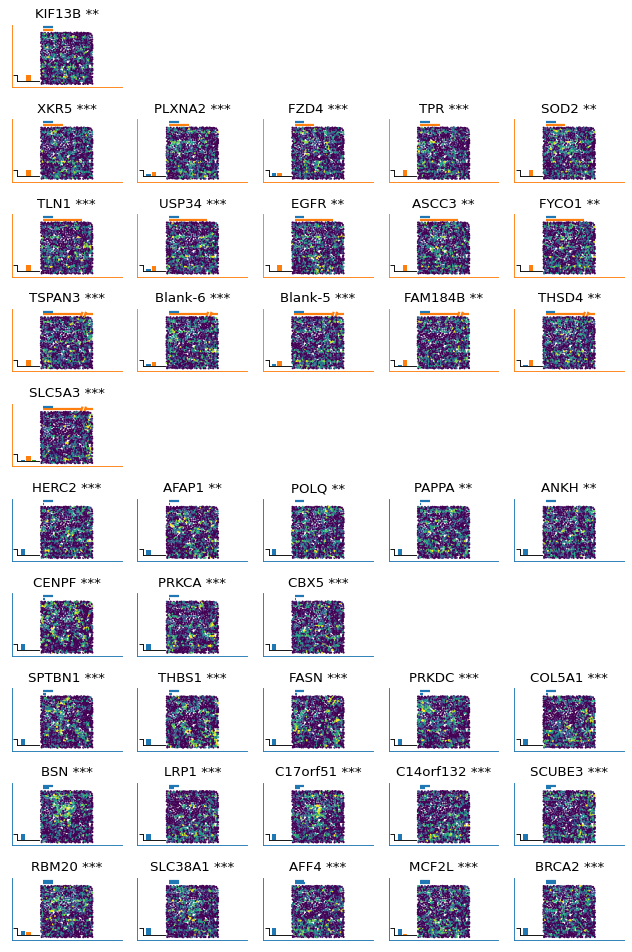

In [37]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.figure(figsize=(8, 12), dpi=80)

N = 5
N_rows = top_per_ls['l'].unique().shape[0]
for j, T in enumerate(top_per_ls.groupby(['model', 'l'])):
    _, group = T
    for i, idx in enumerate(group.index):
        r = top_per_ls.loc[idx]
        ax = plt.subplot(N_rows, N, j * N + i + 1)
        
        plt.scatter(sample_info.abs_X, sample_info.abs_Y,
                    c=scale(res[r['g']], with_std=True), s=1, vmin=0, vmax=2, rasterized=True);
        
        s = ' *'
        if r['qval'] < 0.01:
            s = ' **'

        if r['qval'] < 0.001:
            s = ' ***'

        plt.title(r['g'] + s)
        
        plt.xticks([])
        plt.yticks([])
        plt.hlines(700, -400, -200, lw=2)
        if -400 + r['l'] < 600:
            plt.hlines(650, -400, -400 + r['l'], lw=2, color=model_colors[r['model']], zorder=0)
        else:
            plt.hlines(650, -400, 380, lw=2, color=model_colors[r['model']], zorder=0)
            plt.plot([380 - 10, 380 + 10], [620, 680], lw=2, color=model_colors[r['model']], zorder=0)
            plt.plot([450 - 10, 450 + 10], [620, 680], lw=2, color=model_colors[r['model']], zorder=0)
            plt.hlines(650, 450, 600, lw=2, color=model_colors[r['model']], zorder=0)
            
        for spine in ax.spines.values():
            spine.set_edgecolor(model_colors[r['model']])
        
        plt.axis('equal')
        
        # Make insert with model probabilities
        ins_ax = inset_axes(ax, width='20%', height='10%', loc=3)
        plt.bar((1, 2, 3), top_per_ls.loc[idx][['SE_prob', 'PER_prob', 'linear_prob']], color=['C0', 'C1', 'C2'])
        plt.ylim(0, 1);
        plt.xticks([], [])
        plt.xlim(-0.0, 4)
        plt.yticks([1], ['']);

plt.tight_layout()


In [38]:
blank_genes = results[results.g.str.startswith('Blank-')]['g'].tolist()


In [39]:
len(blank_genes)


10

In [40]:
N = 3
top_per_ls = ms_results.query('g not in @blank_genes and qval < 1e-4') \
                  .sort_values('qval', ascending=True) \
                  .groupby(['model', 'l']) \
                  .head(N) \
                  .sort_values(['l', 'qval'], ascending=[True, True])


<ipython-input-41-c61b1aee61f6>:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  tmp = tmp.drop('max_delta', 1).merge(results[['g', 'max_delta']], on='g')
<ipython-input-41-c61b1aee61f6>:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  tmp = tmp.drop('max_delta', 1).merge(results[['g', 'max_delta']], on='g')


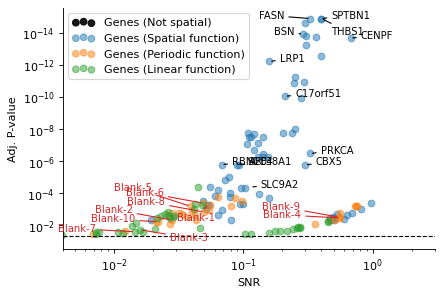

In [41]:
plt.figure(figsize=(6, 4), dpi=80)

plt.xscale('log')
plt.yscale('log')


tmp = results.query('qval > 0.05')
plt.scatter(1./ tmp['max_delta'], tmp['qval'],
            alpha=0.9, rasterized=True, label='Genes (Not spatial)', marker='o', color='k');


tmp = ms_results.query('model == "SE"')
plt.scatter(1./ tmp['max_delta'], tmp['qval'],
            alpha=0.5, rasterized=True, label='Genes (Spatial function)', marker='o', color='C0');

tmp = ms_results.query('model == "PER"')
tmp = tmp.drop('max_delta', 1).merge(results[['g', 'max_delta']], on='g')
plt.scatter(1./ tmp['max_delta'], tmp['qval'],
            alpha=0.5, rasterized=True, label='Genes (Periodic function)', marker='o', color='C1');

tmp = ms_results.query('model == "linear"')
tmp = tmp.drop('max_delta', 1).merge(results[['g', 'max_delta']], on='g')
plt.scatter(1./ tmp['max_delta'], tmp['qval'],
            alpha=0.5, rasterized=True, label='Genes (Linear function)', marker='o', color='C2');

# Annotate negative controls
tmp = results.query('g in @blank_genes')

x_offsets = {'Blank-3': 3e-1,
             'Blank-10': 1.5e0,
             'Blank-1': 9e-1}
y_offsets = {'Blank-3': 2e-1,
             'Blank-5': 1e1,
             'Blank-1': 1e-1,
             'Blank-4': 1e0,
             'Blank-10': 1,
             'Blank-7': 1}
for i, r in tmp.iterrows():
    xy = (1./r['max_delta'], r['qval'])
    xyt = (xy[0] / x_offsets.get(r['g'], 2),
           xy[1] / y_offsets.get(r['g'], 3),)
    plt.annotate(r['g'], xy, xyt, color='tab:red', horizontalalignment='right',
                 arrowprops={'arrowstyle': '-', 'color': 'tab:red'}, size=9)
    
# Annotate top genes
x_offsets = {'FASN': 4e-1,
             'BSN': 6e-1,
             'GTF3C4': 6e-1}
y_offsets = {'THBS1': 1e-1,
             'CDYL2': 1e-1,
             'GTF3C4': 5e0,
             'BRCA2': 3e-1}
for i, r in top_per_ls.iterrows():
    xy = (1./r['max_delta'], r['qval'])
    xyt = (xy[0] * x_offsets.get(r['g'], 1.2),
           xy[1] / y_offsets.get(r['g'], 1),)
    plt.annotate(r['g'], xy, xyt, color='k', arrowprops={'arrowstyle': '-'}, size=9)


plt.xlim(4e-3, 3e0)
plt.axhline(0.05, ls='--', c='k', lw=1)
plt.xlabel('SNR');
plt.ylabel('Adj. P-value');
plt.gca().invert_yaxis()

plt.legend(scatterpoints=3, loc='upper left');


In [42]:
import SpatialDE.plot


/usr/local/lib/python3.8/dist-packages/SpatialDE/plot.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()])


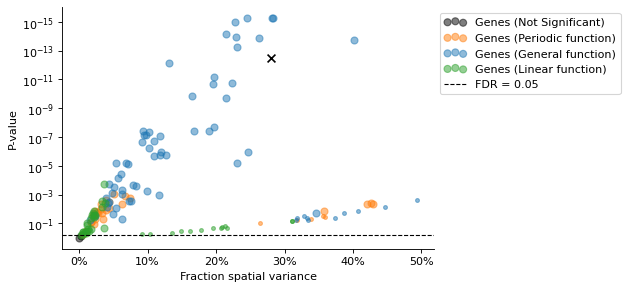

In [43]:
plt.figure(figsize=(6, 4), dpi=80)

SpatialDE.plot.FSV_sig(results, ms_results)


In [44]:
', '.join(results.g.tolist())


'NKTR, SULT1C2, CDYL2, DSEL, DOPEY1, PLXNA2, PROSER1, CBL, KIF13B, FAF2, UBR5, ARL10, FYCO1, AKAP11, SKP1, FZD4, CEMIP, SIPA1L3, PRDM2, BUB3, DIEXF, NRIP1, FBN1, SLC5A3, PAPPA, HERC2, AFAP1, GPR107, ANKH, POLQ, FAM208B, Blank-4, Blank-9, CBX5, CENPF, PRKCA, PRKDC, FBN2, CRTAP, SMARCA5, CKAP5, FASN, THBS1, SPTBN1, PRPF8, ANKRD52, COL5A1, log_total_count, SRRM2, MYH10, AMOTL1, MALAT1, BSN, CHST3, RP4-671O14.6, CREBBP, NHSL2, GTF3C4, SLC7A11, DYNC1H1, CEP250, C17orf51, C14orf132, LRP1, ZNF592, SCUBE3, LUZP1, NOTCH2, AHDC1, TTPAL, MAN1A2, USP34, PTPN14, Blank-1, PIK3CA, Blank-3, PRRC2B, TPR, RNF169, HEATR5B, DIP2B, LMTK2, RNF152, Blank-10, KIAA1462, STARD9, Blank-2, AGPS, SOD2, SLC9A2, USP9X, MED14, YIPF4, ASCC3, AGAP1, SLC35B4, RAD51D, TNRC6A, FZD5, USP8, THSD4, MCF2L, IL17RA, PLXNA1, RAB3B, Blank-7, KLHL9, TSTD2, TMOD2, UMPS, TSPAN3, ZCCHC6, SAMD12, KIAA1147, PHIP, DNAJC13, Blank-8, XKR5, SMIM5, TLN1, FAM184B, Blank-5, AGO3, XDH, CCDC113, EGFR, UBR2, AFF4, Blank-6, IGF2R, ITPR2, ALPK2, S

In [45]:
moffit_genes_plus = ['CENPF', 'CKAP5', 'POLQ', 'BUB3']
moffit_genes_minus = ['THBS1', 'FBN2', 'TSPAN3']


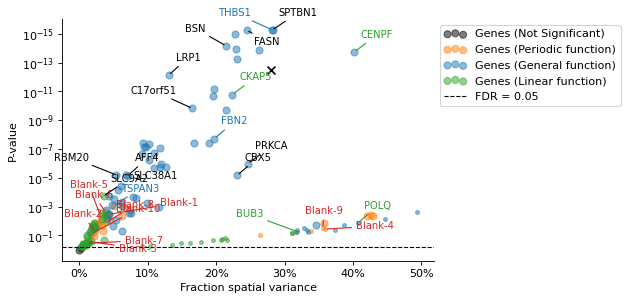

In [46]:
plt.figure(figsize=(6, 4), dpi=80)

SpatialDE.plot.FSV_sig(results, ms_results)
size_stats = results.query('g == "log_total_count"')
# plt.scatter(size_stats['FSV'], size_stats['qval'], marker='x', c='k', s=50)

# Annotate negative controls
tmp = results.query('g in @blank_genes')

x_offsets = {'Blank-3': 0.1,
             'Blank-10': 0.1,
             'Blank-1': 0.1,
             'Blank-9': 0.03,
             'Blank-4': 0.1,
             'Blank-8': 0.07,
             'Blank-1': 0.13,
             'Blank-7': 0.11}
y_offsets = {'Blank-3': 2e-1,
             'Blank-5': 1e2,
             'Blank-1': 4e0,
             'Blank-4': 1e0,
             'Blank-10': 3e1,
             'Blank-7': 1}
for i, r in tmp.iterrows():
    xy = (r['FSV'], r['pval'])
    xyt = (xy[0] + x_offsets.get(r['g'], 0.01),
           xy[1] / y_offsets.get(r['g'], 1e1),)
    plt.annotate(r['g'], xy, xyt, color='tab:red', horizontalalignment='right',
                 arrowprops={'arrowstyle': '-', 'color': 'tab:red'}, size=9)
    

# Annotate highly dividing genes
x_offsets = {'THBS1': -0.08,
             'BSN': -0.06,
             'GTF3C4': 0.1,
             'C17orf51': -0.09,
             'GTF3C4': -0.09,
             'RBM20': -0.09,
             'BRCA2': -0.09,
             'BUB3': -0.09}
y_offsets = {'THBS1': 1e1,
             'CDYL2': 4e-1,
             'GTF3C4': 5e0,
             'BRCA2': 1e1,
             'FASN': 1e-1}
tmp = results.query('g in @moffit_genes_plus')
for i, r in tmp.iterrows():
    xy = (r['FSV'], r['pval'])
    xyt = (xy[0] + x_offsets.get(r['g'], 0.01),
           xy[1] / y_offsets.get(r['g'], 1e1),)
    plt.annotate(r['g'], xy, xyt, color='tab:green', arrowprops={'arrowstyle': '-', 'color': 'tab:green'}, size=9)
    
# Annotate lowly dividing genes
x_offsets = {'THBS1': -0.08,
             'BSN': -0.06,
             'GTF3C4': 0.1,
             'C17orf51': -0.09,
             'GTF3C4': -0.09,
             'RBM20': -0.09,
             'BRCA2': -0.09}
y_offsets = {'THBS1': 1e1,
             'CDYL2': 4e-1,
             'GTF3C4': 5e0,
             'BRCA2': 1e1,
             'FASN': 1e-1}
tmp = results.query('g in @moffit_genes_minus')
for i, r in tmp.iterrows():
    xy = (r['FSV'], r['pval'])
    xyt = (xy[0] + x_offsets.get(r['g'], 0.01),
           xy[1] / y_offsets.get(r['g'], 1e1),)
    plt.annotate(r['g'], xy, xyt, color='tab:blue', arrowprops={'arrowstyle': '-', 'color': 'tab:blue'}, size=9)
    
    
# Annotate top genes
x_offsets = {'THBS1': -0.08,
             'BSN': -0.06,
             'GTF3C4': 0.1,
             'C17orf51': -0.09,
             'GTF3C4': -0.09,
             'RBM20': -0.09,
             'BRCA2': -0.09}
y_offsets = {'THBS1': 1e1,
             'CDYL2': 4e-1,
             'GTF3C4': 5e0,
             'BRCA2': 1e1,
             'FASN': 1e-1,
             'SLC38A1': 5e-1}
tmp = results.query('g in @top_per_ls.g and g not in @moffit_genes_minus and g not in @moffit_genes_plus')
for i, r in tmp.iterrows():
    xy = (r['FSV'], r['pval'])
    xyt = (xy[0] + x_offsets.get(r['g'], 0.01),
           xy[1] / y_offsets.get(r['g'], 1e1),)
    plt.annotate(r['g'], xy, xyt, color='k', arrowprops={'arrowstyle': '-', }, size=9)




In [47]:
results.query('qval < 0.05').shape


(138, 18)

In [48]:
results.query('qval < 0.05').shape[0] / results.shape[0]


0.9857142857142858

In [49]:
results.query('qval < 0.05 & g in @blank_genes').shape


(10, 18)

In [50]:
results.query('qval < 0.05 & g in @blank_genes').shape[0] / results.query('g in @blank_genes').shape[0]


1.0

In [51]:
fdrs = 10 ** np.linspace(0, -8)
total_pct = []
blank_pct = []
for fdr in fdrs:
    total_pct.append(results.query('qval < @fdr').shape[0] / results.shape[0])
    blank_pct.append(results.query('qval < @fdr & g in @blank_genes').shape[0] / results.query('g in @blank_genes').shape[0])


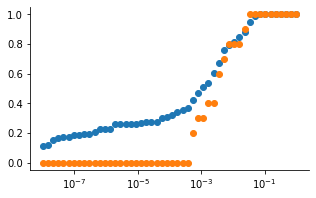

In [52]:
figsize(5, 3)
plt.xscale('log')
plt.scatter(fdrs, total_pct);
plt.scatter(fdrs, blank_pct);


In [53]:
results.shape


(140, 18)

In [54]:
results['bpval'] = results.pval * results.shape[0]


In [55]:
fdrs = 10 ** np.linspace(0, -8)
total_pct = []
blank_pct = []
for fdr in fdrs:
    total_pct.append(results.query('bpval < @fdr').shape[0] / results.shape[0])
    blank_pct.append(results.query('bpval < @fdr & g in @blank_genes').shape[0] / results.query('g in @blank_genes').shape[0])


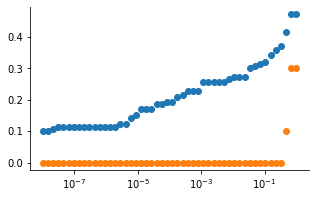

In [56]:
figsize(5, 3)
plt.xscale('log')
plt.scatter(fdrs, total_pct);
plt.scatter(fdrs, blank_pct);


In [57]:
results['bp_blanks'] = results.pval * 10


In [58]:
results['bp_rna'] = results.pval * (results.shape[0] - 10)


In [59]:
fdrs = 10 ** np.linspace(2, -10)
total_pct = []
blank_pct = []
for fdr in fdrs:
    total_pct.append(results.query('bp_rna < @fdr').shape[0] / results.shape[0])
    blank_pct.append(results.query('bp_blanks < @fdr & g in @blank_genes').shape[0] / results.query('g in @blank_genes').shape[0])


In [60]:
results.shape[0] - 10


130

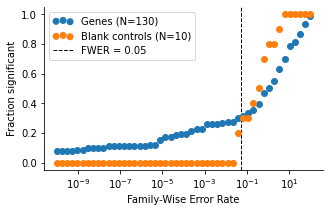

In [61]:
figsize(5, 3)
plt.xscale('log')
plt.scatter(fdrs, total_pct, label='Genes (N=130)');
plt.scatter(fdrs, blank_pct, label='Blank controls (N=10)');
plt.axvline(0.05, lw=1, ls='--', c='k', zorder=0, label='FWER = 0.05');
plt.legend(scatterpoints=3);

plt.ylabel('Fraction significant');
plt.xlabel('Family-Wise Error Rate');


In [62]:
results.query('bp_blanks < 0.05 & g in @blank_genes')


,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,...,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval,bpval,bp_blanks,bp_rna
73,0.042966,4,Blank-1,205.398037,18.558303,-728.438416,-3.734378,0.093120,SE,1056,...,0.125081,0.007715,1484.725806,-736.997582,8.559165,0.003438,0.000530,0.481302,0.034379,0.446923
121,0.031503,4,Blank-5,205.398037,25.613997,-693.180259,-3.749111,0.085449,SE,1056,...,0.102821,0.014757,1414.209492,-701.160850,7.980591,0.004728,0.000661,0.661941,0.047282,0.614660
128,0.038852,4,Blank-6,205.398037,20.611485,-616.849123,-3.534902,0.080177,SE,1056,...,0.126994,0.012516,1261.547219,-626.037892,9.188769,0.002435,0.000414,0.340906,0.024350,0.316556
